# Search for Microlensing events in DP1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.lines as mlines
import itertools
from astropy.coordinates import SkyCoord
import astropy.units as u

from lsst.rsp import get_tap_service
from lsst.daf.butler import Butler
import lsst.afw.display as afw_display
import lsst.sphgeom as sphgeom
import lsst.geom as geom
from lsst.utils.plotting import (get_multiband_plot_colors,
                                 get_multiband_plot_symbols,
                                 get_multiband_plot_linestyles)
import pandas as pd
from scipy.optimize import minimize
import warnings
import weightedstats as ws

In [3]:
service = get_tap_service("tap")
assert service is not None

In [4]:
butler = Butler('dp1', collections="LSSTComCam/DP1")
assert butler is not None

In [59]:
ra_cen = 95.0 # 53.45
dec_cen = -25.0 # -28.38
radius = 1.3
region = sphgeom.Region.from_ivoa_pos(f"CIRCLE {ra_cen} {dec_cen} {radius}")

In [6]:
query = f"""
        SELECT
  fsodo.diaObjectId,
  fsodo.coord_ra,
  fsodo.coord_dec,
  COUNT(*) AS visit_count
FROM dp1.ForcedSourceOnDiaObject AS fsodo
JOIN dp1.Visit AS vis ON fsodo.visit = vis.visit
WHERE
  fsodo.band = 'r'
  AND CONTAINS(
    POINT('ICRS', fsodo.coord_ra, fsodo.coord_dec),
    CIRCLE('ICRS', {ra_cen}, {dec_cen}, {radius})
  ) = 1
GROUP BY
  fsodo.diaObjectId,
  fsodo.coord_ra,
  fsodo.coord_dec
HAVING
  COUNT(*) > 10
"""

In [249]:
query = f"""
    SELECT
      fsodo.diaObjectId,
      fsodo.coord_ra,
      fsodo.coord_dec,
      COUNT(*) AS positive_flux_count
    FROM dp1.ForcedSourceOnDiaObject AS fsodo
    JOIN dp1.Visit AS vis ON fsodo.visit = vis.visit
    WHERE
      fsodo.band = 'r'
      AND fsodo.psfFlux > 0
      AND CONTAINS(
        POINT('ICRS', fsodo.coord_ra, fsodo.coord_dec),
        CIRCLE('ICRS', {ra_cen}, {dec_cen}, {radius})
      ) = 1
    GROUP BY
      fsodo.diaObjectId,
      fsodo.coord_ra,
      fsodo.coord_dec
    HAVING
      COUNT(*) > 10
"""


In [270]:
query = "SELECT ra, dec, diaObjectId, "\
        "r_psfFluxMean, nDiaSources, r_scienceFluxMean, "\
        "r_psfFluxNdata, r_psfFluxMax,r_psfFluxMin, r_psfFluxLinearSlope "\
        "FROM dp1.DiaObject "\
        "WHERE CONTAINS (POINT('ICRS', ra, dec), "\
        "CIRCLE('ICRS'," + str(ra_cen) + ", "\
        + str(dec_cen) + ", 2)) = 1 "

In [272]:
DiaObjsFull = job.fetch_result().to_table()
DiaObjsFull['r_fluxamp'] = DiaObjsFull['r_psfFluxMax'] - DiaObjsFull['r_psfFluxMin']

In [281]:
print(str(len(DiaObjsFull))+' DiaObjects from initial query.')
DiaObjsFull['r_fluxamp'] = DiaObjsFull['r_psfFluxMax'] - DiaObjsFull['r_psfFluxMin']
# DiaObjs = DiaObjsFull[DiaObjsFull['nDiaSources'] > 5]
DiaObjs = DiaObjsFull[DiaObjsFull['r_scienceFluxMean'] < 10**5.5]
#DiaObjs = DiaObjs[DiaObjs['r_psfFluxNdata'] > 10]
#DiaObjs = DiaObjs[(DiaObjs['r_psfFluxLinearSlope']/DiaObjs['r_psfFluxMax'] < -0.03)
#                  & (DiaObjs['r_psfFluxLinearSlope']/DiaObjs['r_psfFluxMax'] > -0.07)]
#DiaObjs = DiaObjs[DiaObjs['r_fluxamp'] > 0.1*DiaObjs['r_scienceFluxMean']]
DiaObjs.sort('r_fluxamp', reverse=True)
print(str(len(DiaObjs))+' SNIa candidates.')

238857 DiaObjects from initial query.
83024 SNIa candidates.


In [271]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()
assert job.phase == 'COMPLETED'

Job phase is COMPLETED


In [279]:
DiaObjsFull[DiaObjsFull['diaObjectId']==612929147815070120]

ra,dec,diaObjectId,r_psfFluxMean,nDiaSources,r_scienceFluxMean,r_psfFluxNdata,r_psfFluxMax,r_psfFluxMin,r_psfFluxLinearSlope,r_fluxamp
deg,deg,,,,,,,,,
float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64
95.30136707915997,-25.394771985704697,612929147815070120,--,1,--,--,--,--,--,--


In [ ]:
objtab = job.fetch_result().to_table()

In [243]:
# ATOUSHA'S IMPLEMENTATION OF THE KMTNet DETECTION ALGORITHM
# --- Model Definitions ---
# Functions for high and low magnification regimes,
# params: (t, f_1, f_0, t0, t_eff)

def Ft_high(t, f_1, f_0, t0, t_eff):
    # High-mag analytic approximation 
    Q = 1 + ((t - t0) / t_eff)**2
    return np.abs(f_1) * (Q**(-1.0 / 2)) + np.abs(f_0)

def Ft_low(t, f_1, f_0, t0, t_eff):
     # Low-mag analytic approximation
    Q = 1 + ((t - t0) / t_eff)**2
    return np.abs(f_1) * (1 - (1 + Q / 2)**-2)**(-1.0 / 2) + np.abs(f_0)

 # --- Chi2 Functions for Minimization ---
def chi2_high(f_params, t, flux, flux_err, t0, teff):
    # Compute chi^2 for the high-mag model (minimize over f1, f0)
    f_1, f_0 = f_params
    model = Ft_high(t, f_1, f_0, t0, teff)
    inv_sigma2 = 1.0 / (flux_err**2)
    return np.sum((flux - model)**2 * inv_sigma2)

def chi2_low(f_params, t, flux, flux_err, t0, teff):
    # Compute chi^2 for the low-mag model
    f_1, f_0 = f_params
    model = Ft_low(t, f_1, f_0, t0, teff)
    inv_sigma2 = 1.0 / (flux_err**2)
    return np.sum((flux - model)**2 * inv_sigma2)
    
def run_kmtnet_fit(times, fluxes, flux_errors):

    """
    Fit a two-parameter PSPL (KMTNet-Algorithm) model to a light curve,
    using a grid search over t0 and t_eff,
    and return Delta_Chi2 along with best-fit parameters.
    """

    # Ensure inputs are numpy arrays
    times = np.asarray(times)
    fluxes = np.asarray(fluxes)
    flux_errors = np.asarray(flux_errors)

    # Filter out NaNs from input data before creating DataFrame
    valid_data_indices = ~np.isnan(times) & ~np.isnan(fluxes) & ~np.isnan(flux_errors) & (flux_errors > 0)
    times, fluxes, flux_errors = times[valid_data_indices], fluxes[valid_data_indices], flux_errors[valid_data_indices]

    if len(times) < 4: # KMTNet fit needs sufficient data points
        return None, (None, None, None, None) # Not enough data for KMTNet fit

    data_df = pd.DataFrame({
        'time': times,
        'flux': fluxes,
        'flux_err': flux_errors
    })




        

    # --- Grid Search: Build t0-teff grid for nonlinear fitting ---
    teff_min, teff_max = 1, 100
    teff_list, t0_tE_list = [], []
    current_teff = teff_min




    
    # Build teff grid (teff_{k+1} = (1 + delta) * teff_k)
    while current_teff <= teff_max:
        teff_list.append(current_teff)
        delta = 1/5 if current_teff < 1 else 1/3
        current_teff *= (1 + delta)

    # For each teff, build the grid of t0 values
    t0_min, t0_max = np.min(times), np.max(times)
    for teff in teff_list:
        t0_current = t0_min
        while t0_current <= t0_max:
            t0_tE_list.append([t0_current, teff])
            delta = 1/5 if teff < 1 else 1/3
            t0_current += delta * teff

    # If no grid was produced, exit
    if not t0_tE_list: return None, (None, None, None, None)


    # --- Main Grid Fit Loop ---
    param1, param2 = [], []  # Will store fit results for high and low mag regimes
    f_initial = [0.01, 0.99] # Initial guess for f_1, f_0

    for i, (t0_val, teff_val) in enumerate(t0_tE_list):
        # For each grid point, select data within the relevant window (t0 ± 7 teff)
        df_i = data_df[(data_df['time'] > (t0_val - 7 * teff_val)) & (data_df['time'] < (t0_val + 7 * teff_val))]

        if len(df_i) < 10:
            continue # Skip if not enough data in interval

        # Prepare arguments for minimize (t, flux, flux_err, t0_val, teff_val)
        args = (df_i['time'].values, df_i['flux'].values, df_i['flux_err'].values, t0_val, teff_val)

        try:
            # Fit the high-magnification model for current grid point
            result1 = minimize(chi2_high, f_initial, args=args, method='Nelder-Mead')
            # Compute chi2 for the entire dataset using best-fit parameters
            model_diff1 = data_df['flux'].values - Ft_high(data_df['time'].values, result1.x[0], result1.x[1], t0_val, teff_val)
            chi2_all1 = np.sum((model_diff1)**2 * (1.0 / (data_df['flux_err'].values**2)))


            # Fit the low-magnification model
            result2 = minimize(chi2_low, f_initial, args=args, method='Nelder-Mead')
            model_diff2 = data_df['flux'].values - Ft_low(data_df['time'].values, result2.x[0], result2.x[1], t0_val, teff_val)
            chi2_all2 = np.sum((model_diff2)**2 * (1.0 / (data_df['flux_err'].values**2)))

            # Store: [index, t0, teff, f1, f0, local_chi2, window_npts, global_chi2, npts]
            param1.append([i, t0_val, teff_val, result1.x[0], result1.x[1], result1.fun,
                            len(df_i), chi2_all1, len(data_df)])
            param2.append([i, t0_val, teff_val, result2.x[0], result2.x[1], result2.fun,
                            len(df_i), chi2_all2, len(data_df)])
        except Exception as e:
            # If optimization fails, print a warning but continue
            print(f"Warning: KMTNet minimize failed for iteration {i}: {e}")
            continue 

    # If no fits were successful, exit
    if not param1 and not param2: return None, (None, None, None, None)

    # --- Select Best-fit Parameters ---
    # Find best fits: lowest chi2 on entire dataset for both regimes
    min_value1 = min(param1, key=lambda x: x[7])
    min_value2 = min(param2, key=lambda x: x[7])

    # Use the regime (high or low mag) with the best global chi2
    if min_value1 < min_value2:
              min_value = min_value1
              param = param1
              F_t = Ft_high
              which_regim = 'high'

    else:
              min_value = min_value2
              param = param2
              F_t = Ft_low
              which_regim = 'low'

    # Extract the precise parameters where chi2 is minimized
    for sublist in param:
        if sublist[7] == min_value[7]:
            parameter = sublist



    chi_mlens = parameter[7] # Minimum chi2 for microlensing fit
    t0 = parameter[1]
    t_eff = parameter[2]
    f1 = parameter[3]
    f0 = parameter[4]

    # --- Linear Fit for Flat Model ---
    # Fit a constant flux to the light curve in the same window
    data_df_interval = data_df[(data_df['time'] > (t0 - 7 * t_eff)) & (data_df['time'] < (t0 + 7 * t_eff))]

    if len(data_df_interval) == 0:
        # Fallback to global mean if window is empty
        mean_flux_interval = np.mean(data_df['flux'].values)
    else:
        # Ensure weights are valid (not zero or inf)
        weights = 1.0 / (data_df_interval['flux_err'].values**2)
        valid_weights_indices = ~np.isinf(weights) & ~np.isnan(weights) & (weights > 0)
        if np.sum(valid_weights_indices) > 0:
            mean_flux_interval = ws.weighted_mean(data_df_interval['flux'].values[valid_weights_indices],
                                                  weights[valid_weights_indices])
        else:
            mean_flux_interval = np.mean(data_df['flux'].values)

    # Compute chi2 for flat line fit
    chi2_linearfit = np.sum((data_df['flux'] - mean_flux_interval)**2 / (data_df['flux_err']) ** 2)


     # --- Compute Metric and Return ---
    if chi2_linearfit == 0:
        delta_chi_squared_kmt = 0
    else:
        delta_chi_squared_kmt = (abs(chi_mlens - chi2_linearfit) / chi2_linearfit)

    # Return: delta chi2, best-fit physical params
    # If delta_chi_squared_kmt > 0.9, the light curve would be a microlensing candidate.
    return delta_chi_squared_kmt, (t0, t_eff, f1, f0), which_regim


 -> Found 13 r-band observations
13
Extracting lightcurve for 612929147815070120


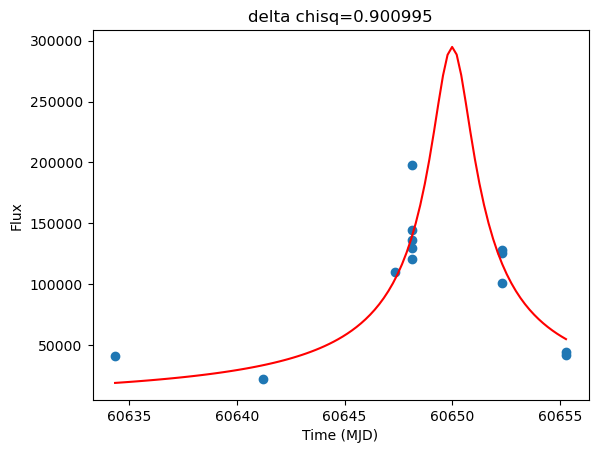

In [299]:
# single object fit
ID = 612929147815070120
target = DiaObjsFull[DiaObjsFull['diaObjectId']==ID]
query = "SELECT fsodo.coord_ra, fsodo.coord_dec, "\
        "fsodo.diaObjectId, fsodo.visit, fsodo.band, "\
        "fsodo.psfDiffFlux, fsodo.psfDiffFluxErr, "\
        "fsodo.psfFlux as psfFlux, fsodo.psfFluxErr, "\
        "vis.expMidptMJD "\
        "FROM dp1.ForcedSourceOnDiaObject as fsodo "\
        "JOIN dp1.Visit as vis ON vis.visit = fsodo.visit "\
        "WHERE fsodo.diaObjectId = "+str(ID)

job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])

#print(f"Searching at coords: {target['ra'].data[0]}  {target['dec'].data[0]} {repr(job.phase)}")
if job.phase == 'ERROR':
    job.raise_if_error()
assert job.phase == 'COMPLETED'

forced_sources = job.fetch_result().to_table()
print(' -> Found', np.sum(forced_sources['band'] == 'r'), 'r-band observations')

rband = np.where(forced_sources['band'] == 'r')

times = forced_sources[rband]['expMidptMJD']
fluxes = forced_sources[rband]['psfFlux']
flux_err = forced_sources[rband]['psfFluxErr']
fluxes_diff = forced_sources[rband]['psfDiffFlux']
flux_err_diff = forced_sources[rband]['psfDiffFluxErr']

print(np.sum(fluxes>0))

plt.figure(i)
plt.scatter(times, fluxes)
#plt.scatter(times, fluxes_diff)


print(f'Extracting lightcurve for {target["diaObjectId"].data[0]}')

delta_chi_squared_kmt, (t0, t_eff, f1, f0), which_regim = run_kmtnet_fit(times, fluxes, flux_err)
#delta_chi_squared_kmt, (t0, t_eff, f1, f0) = run_kmtnet_fit(times, fluxes_diff, flux_err_diff)


times_new = np.linspace(min(times),
                       max(times),
                       100)
if which_regim=='high':
    model = Ft_high(times_new, f1, f0, t0, t_eff)
if which_regim=='low':
    model = Ft_low(times_new, f1, f0, t0, t_eff)

plt.plot(times_new, model, 'r')

if delta_chi_squared_kmt is None:
    pass
else:
    plt.title('delta chisq='+str(np.round(delta_chi_squared_kmt, 6)))
plt.ylabel('Flux')
plt.xlabel('Time (MJD)')
plt.show()

In [297]:
delta_chi_squared_kmt, (t0, t_eff, f1, f0), which_regim

(np.float64(0.9009950512935414),
 (np.float64(60650.00195377906),
  1,
  np.float64(294851.9681634888),
  np.float64(-9.250079021927072e-12)),
 'high')

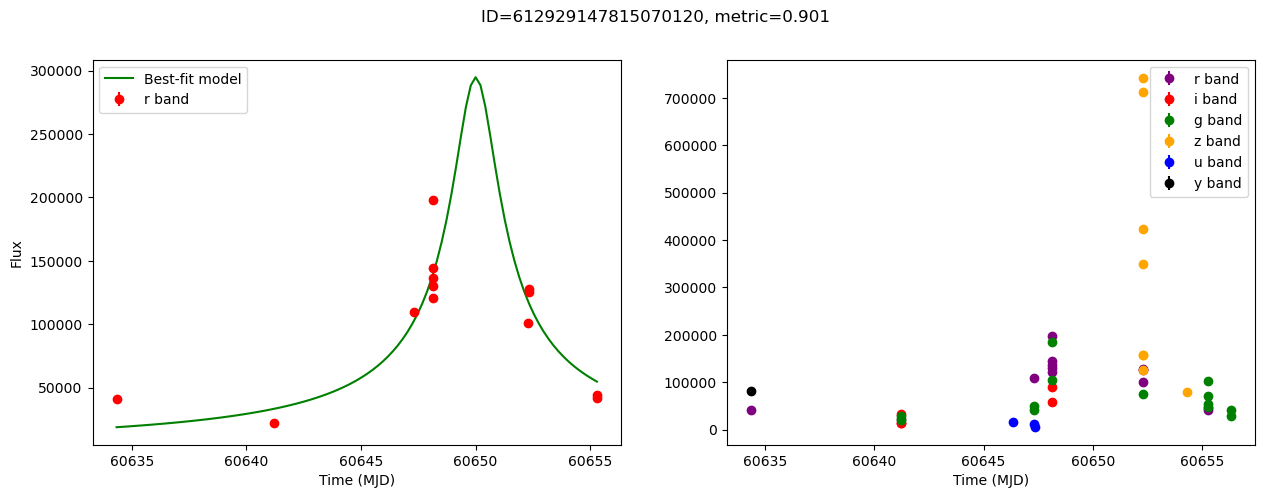

In [302]:
import astropy.units as u

fig, axs = plt.subplots(1, 2, figsize=(15,5))
colors = ['purple', 'r', 'g', 'orange', 'blue', 'k']
all_bands = ['r', 'i', 'g', 'z', 'u', 'y']
for b, band in enumerate(all_bands):
    band_ind = np.where(forced_sources['band'] == band)
    rband = np.where(forced_sources['band'] == 'r')
    times = forced_sources[band_ind]['expMidptMJD']
    fluxes = forced_sources[band_ind]['psfFlux']
    flux_err = forced_sources[band_ind]['psfFluxErr']
    fluxes_diff = forced_sources[band_ind]['psfDiffFlux']
    flux_err_diff = forced_sources[band_ind]['psfDiffFluxErr']

    axs[1].errorbar(times, 
                    fluxes, 
                    yerr=flux_err, 
                    fmt='o',
                    color=colors[b], 
                    label=all_bands[b]+' band')
    #plt.errorbar(times, fluxes_diff,yerr= flux_err_diff, fmt='o', color=colors[b], label=all_bands[b]+' band')

axs[0].errorbar(forced_sources[rband]['expMidptMJD'], 
               forced_sources[rband]['psfFlux'], 
                yerr=forced_sources[rband]['psfFluxErr'],
                fmt='o',
               color='r', 
               label='r band')
axs[0].plot(times_new, 
            model,
            color='g',
           label = 'Best-fit model')
plt.suptitle('ID=%i, metric=%.3f'%(target["diaObjectId"].data[0], delta_chi_squared_kmt))
axs[0].set_ylabel('Flux')
axs[0].set_xlabel('Time (MJD)')
axs[1].set_xlabel('Time (MJD)')

axs[0].legend()
axs[1].legend()
#plt.savefig('%i.png'%target["diaObjectId"].data[0])
#plt.xlim(60646.05, 60646.1)
plt.show()

In [102]:
flux_err_diff

1897.63


Searching at coords: 95.35106829445591  -25.37793186077392 'COMPLETED'
 -> Found 13 r-band observations
Extracting lightcurve for 612929079095591015


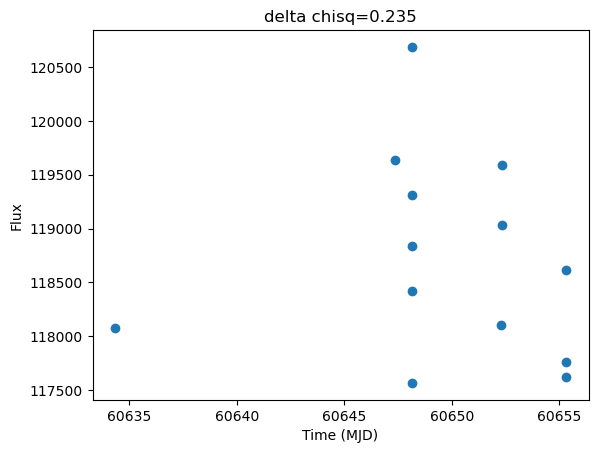

Searching at coords: 95.34537176082017  -25.3833221054763 'COMPLETED'
 -> Found 12 r-band observations
Extracting lightcurve for 612929079095591016


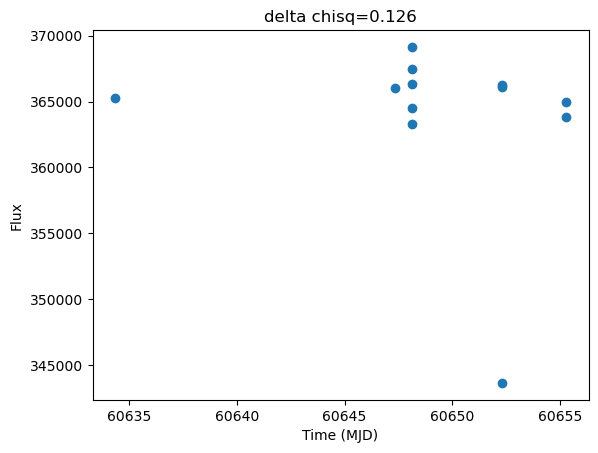

Searching at coords: 95.34455128915458  -25.374719726462157 'COMPLETED'
 -> Found 14 r-band observations
Extracting lightcurve for 612929079095591020


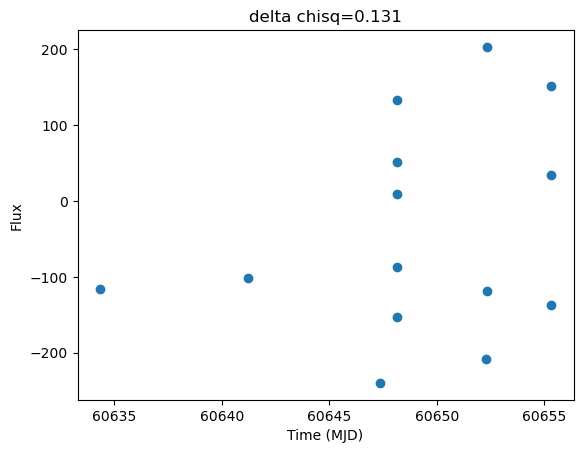

Searching at coords: 95.36048153017475  -25.37850149395651 'COMPLETED'
 -> Found 11 r-band observations
Extracting lightcurve for 612929079095591042


KeyboardInterrupt: 

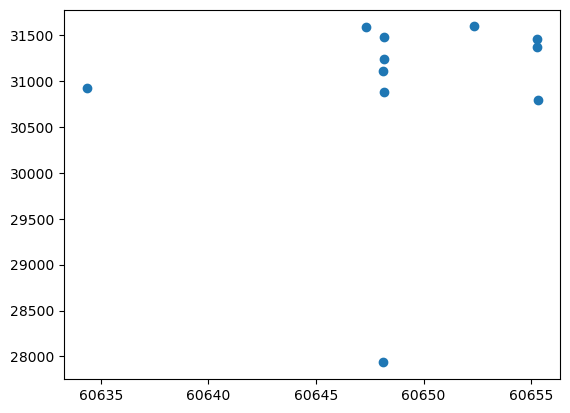

In [12]:
target_radius = 0.5 / 3600.0  # degrees

with open('./mulens_candidates.dat', 'w') as fout:
    fout.write('# diaObjectId   coord_ra  coord_dec  delta_chi_squared_kmt  t0  t_eff  f1  f0\n')

    i = 0
    maxi = len(objtab)
    while i < maxi:  
        target = objtab[i]
        
        query = f"""
            SELECT fsodo.diaObjectId, fsodo.coord_ra, fsodo.coord_dec,
                   fsodo.visit, fsodo.detector, fsodo.band,
                   fsodo.psfDiffFlux, fsodo.psfDiffFluxErr,
                   fsodo.psfFlux AS psfFlux, fsodo.psfFluxErr,
                   vis.expMidptMJD
            FROM dp1.ForcedSourceOnDiaObject AS fsodo
            JOIN dp1.Visit AS vis ON vis.visit = fsodo.visit
            WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),
                           CIRCLE('ICRS', {target['coord_ra']}, {target['coord_dec']}, {target_radius})) = 1
        """

        job = service.submit_job(query)
        job.run()
        job.wait(phases=['COMPLETED', 'ERROR'])

        print(f"Searching at coords: {target['coord_ra']}  {target['coord_dec']} {repr(job.phase)}")
        if job.phase == 'ERROR':
            job.raise_if_error()
        assert job.phase == 'COMPLETED'

        forced_sources = job.fetch_result().to_table()
        print(' -> Found', np.sum(forced_sources['band'] == 'r'), 'r-band observations')

        if len(forced_sources) > 0:
            rband = np.where(forced_sources['band'] == 'r')
            if len(rband[0]) < 10:  #skip poor light curves
                i += 1
                continue

            times = forced_sources[rband]['expMidptMJD']
            fluxes = forced_sources[rband]['psfFlux']
            flux_err = forced_sources[rband]['psfFluxErr']

            plt.figure(i)
            plt.scatter(times, fluxes)
            

            print(f'Extracting lightcurve for {target["diaObjectId"]}')

            delta_chi_squared_kmt, (t0, t_eff, f1, f0) = run_kmtnet_fit(times, fluxes, flux_err)

            plt.title('delta chisq='+str(np.round(delta_chi_squared_kmt, 3)))
            plt.ylabel('Flux')
            plt.xlabel('Time (MJD)')
            plt.show()

            if delta_chi_squared_kmt > 0.9:
                fout.write(f"{target['diaObjectId']}  {target['coord_ra']}  {target['coord_dec']}  "
                           f"{delta_chi_squared_kmt}  {t0}  {t_eff}  {f1}  {f0}\n")

        i += 1
        if i == 10:
            break

In [18]:
import multiprocessing

target_radius = 0.5 / 3600.0  # degrees

def chunked(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def process_light_curve(dict_lc):
            ID = list(dict_lc.keys())[0]
            time = dict_lc[ID]['time']
            flux = dict_lc[ID]['flux']
            flux_err = dict_lc[ID]['flux_err']
            delta_chi_squared_kmt, (t0, t_eff, f1, f0) = run_kmtnet_fit(time, flux, flux_err)
            if delta_chi_squared_kmt > 0.9:
                fout.write(f"{ID}  {dict_lc[ID]['ra_coor']}  {dict_lc[ID]['dec_coor']}  "
                           f"{delta_chi_squared_kmt}  {t0}  {t_eff}  {f1}  {f0}\n")
                # plt.figure(int(ID))
                # plt.scatter(times, fluxes)
                # plt.title('delta chisq='+str(np.round(delta_chi_squared_kmt, 3)))
                # plt.ylabel('Flux')
                # plt.xlabel('Time (MJD)')
                # plt.show()
                
multiprocessing.set_start_method('spawn')
num_cores = multiprocessing.cpu_count()
print('Number of cores are:', num_cores)

with open('./mulens_candidates.dat', 'w') as fout:
    fout.write('# diaObjectId   coord_ra  coord_dec  delta_chi_squared_kmt  t0  t_eff  f1  f0\n')

    i = 0
    IDs = np.array(objtab['diaObjectId'].data)
    for chunk in chunked(IDs, 100):
        ids_str = ",".join(str(i) for i in chunk)  
        
        
        query = f"""
            SELECT fsodo.diaObjectId, fsodo.coord_ra, fsodo.coord_dec,
                   fsodo.visit, fsodo.detector, fsodo.band,
                   fsodo.psfDiffFlux, fsodo.psfDiffFluxErr,
                   fsodo.psfFlux AS psfFlux, fsodo.psfFluxErr,
                   vis.expMidptMJD
            FROM dp1.ForcedSourceOnDiaObject AS fsodo
            JOIN dp1.Visit AS vis ON vis.visit = fsodo.visit
            WHERE fsodo.diaObjectId IN ({ids_str})
        """

        job = service.submit_job(query)
        job.run()
        job.wait(phases=['COMPLETED', 'ERROR'])

        
        if job.phase == 'ERROR':
            job.raise_if_error()
        assert job.phase == 'COMPLETED'

        forced_sources = job.fetch_result().to_table()
        all_data = forced_sources[forced_sources['band']=='r']
        all_data_list = []
        for ID in ids_str.split(','):
            target = objtab[objtab['diaObjectId']== int(ID)]
            all_data_list.append(
                {ID: {'ra_coor':target['coord_ra'],
                      'dec_coor':target['coord_dec'],
                     'time': np.array(all_data[all_data['diaObjectId'] == int(ID)]['expMidptMJD'].data),
                     'flux': np.array(all_data[all_data['diaObjectId'] == int(ID)]['psfFlux'].data),
                     'flux_err': np.array(all_data[all_data['diaObjectId'] == int(ID)]['psfFluxErr'].data)}}
            )

        

        while len(all_data_list) > 0:
            # print('Step: ', counter)
            num_to_process = min(num_cores, len(all_data_list) )
            
            batch = all_data_list[:num_to_process]
            
            # Remove the processed objects from the list
            all_data_list = all_data_list[num_to_process:]
            
            pool = multiprocessing.Pool(processes=num_to_process)
                
            pool.map(process_light_curve, batch)
            pool.close()
            pool.join()


Number of cores are: 32


Process ForkPoolWorker-202:
Process ForkPoolWorker-199:
Process ForkPoolWorker-194:
Process ForkPoolWorker-216:
Process ForkPoolWorker-201:
Process ForkPoolWorker-195:
Process ForkPoolWorker-203:
Process ForkPoolWorker-206:
Process ForkPoolWorker-205:
Process ForkPoolWorker-217:
Process ForkPoolWorker-207:
Process ForkPoolWorker-212:
Process ForkPoolWorker-218:
Process ForkPoolWorker-215:
Process ForkPoolWorker-204:
Process ForkPoolWorker-210:
Process ForkPoolWorker-208:
Process ForkPoolWorker-219:
Process ForkPoolWorker-224:
Process ForkPoolWorker-200:
Process ForkPoolWorker-214:


KeyboardInterrupt: 

Process ForkPoolWorker-221:
Process ForkPoolWorker-223:
Process ForkPoolWorker-213:
Process ForkPoolWorker-211:
Process ForkPoolWorker-196:
Process ForkPoolWorker-193:
Process ForkPoolWorker-222:
Process ForkPoolWorker-220:
Process ForkPoolWorker-209:
Process ForkPoolWorker-197:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/lsst/software/stack/conda/envs/lsst-scipip

In [12]:
IDs = np.array(objtab['diaObjectId'].data)
ids_str = ",".join(str(i) for i in IDs)

In [13]:
query = f"""
    SELECT fsodo.diaObjectId, fsodo.coord_ra, fsodo.coord_dec,
           fsodo.visit, fsodo.detector, fsodo.band,
           fsodo.psfDiffFlux, fsodo.psfDiffFluxErr,
           fsodo.psfFlux AS psfFlux, fsodo.psfFluxErr,
           vis.expMidptMJD
    FROM dp1.ForcedSourceOnDiaObject AS fsodo
    JOIN dp1.Visit AS vis ON vis.visit = fsodo.visit
    WHERE fsodo.diaObjectId IN ({ids_str})
"""

job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])


if job.phase == 'ERROR':
    job.raise_if_error()
assert job.phase == 'COMPLETED'

forced_sources = job.fetch_result().to_table()

DALQueryError: Query Error: IllegalArgumentException:missing required parameter: LANG